# 有针对性的直接营销

---

## 背景
通过邮件、电子邮件、电话等方式进行直接营销是获取客户的常用策略。由于资源和客户的注意力有限，因此营销必须面向有可能购买特定商品的部分潜在客户。根据人口统计数据、历史互动记录和环境因素等容易获得的信息来预测这类潜在客户，是一个常见的机器学习问题。

此笔记本提供了一个示例问题：预测客户是否会在销售人员打过一次或多次电话后，在银行办理定期存款。步骤如下：

* 准备 Amazon SageMaker 笔记本
* 将网上的数据下载到 Amazon SageMaker 中
* 调查并转换数据，以便能够将其提供给 Amazon SageMaker 算法
* 估计模型 
* 评估模型效果
* 将模型设置为进行持续的预测

---

## 准备工作

*该笔记本是在 ml.m5.xlarge 笔记本实例上创建和测试的。*

首先指定：

- 要用于训练和模型数据的 Amazon Simple Storage Service (Amazon S3) 存储桶和前缀。它们应与笔记本实例、训练和托管位于同一区域。
- 用于提供数据访问权限以便进行训练和托管的 AWS Identity and Access Management (IAM) 角色的 Amazon 资源名称 (ARN)。请参阅文档，了解如何创建这些角色。

**注意**：如果笔记本实例、训练和/或托管需要多个角色，请用适当的完整 IAM 角色 ARN 字符串替换 boto regexp。

用实验账户提供的资源名称替换 **`<LabBucketName>`**。

In [1]:
bucket = 'ml-pipeline-bucket'
prefix = 'sagemaker/DEMO-xgboost-dm'
 
# 定义 IAM 角色
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

导入要在分析过程中使用的 Python 库。

In [2]:
import numpy as np # 用于矩阵运算和数值处理
import pandas as pd # 用于规整表格式数据
import matplotlib.pyplot as plt # 用于绘图和进行可视化
from IPython.display import Image # 用于在笔记本中显示图片
from IPython.display import display # 用于在笔记本中显示输出
from time import gmtime, strftime # 用于标记 Amazon SageMaker 模型和终端节点等
import sys # 用于将输出写入笔记本
import math # 用于 ceiling 函数
import json # 用于解析托管输出
import os # 用于操作文件路径名称
import sagemaker # Amazon SageMaker 的 Python 开发工具包提供了许多辅助函数。
from sagemaker.predictor import csv_serializer # 转换有关推理的 HTTP POST 请求的字符串

---

## 数据
首先从加州大学欧文分校 (UCI) 机器学习 ML 库中下载 [银行营销数据集](https://archive.ics.uci.edu/ml/datasets/bank+marketing)。

**来源信息**：

S.Moro、P. Cortez 和 P. Rita。A Data-Driven Approach to Predict the Success of Bank Telemarketing（一种用于预测银行电话营销成功率的数据驱动型方法）。Decision Support Systems (Elsevier) 2014 年 6 月第 62 卷：22-31

In [3]:
!aws s3 cp s3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/lab1/bank-additional.zip .
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip -o bank-additional.zip

download: s3://aws-tc-largeobjects/ILT-TF-200-MLDWTS/lab1/bank-additional.zip to ./bank-additional.zip
Archive:  bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/.DS_Store  
  inflating: bank-additional/bank-additional-names.txt  
  inflating: bank-additional/bank-additional.csv  
  inflating: bank-additional/bank-additional-full.csv  


现在，将其读入 Pandas DataFrame 并进行查看。

In [4]:
data = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')
pd.set_option('display.max_columns', 500) # 确保可以看到所有列
pd.set_option('display.max_rows', 20) # 确保输出都在一页上

In [5]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


下面来了解一下数据。概括来说，我们发现：

* 客户记录只有 4 万条多一点点，每位客户的特征也只有 20 个。
* 既有数值型特征，也有分类型特征。
* 数据似乎至少按 `time` 和 `contact` 进行了排序。


### 探索
接着探索数据。我们先来了解特征的分布情况。

In [6]:
# 每个分类型特征的频率表
for column in data.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=data[column], columns='% observations', normalize='columns')*100)

col_0,% observations
job,
admin.,25.303486
blue-collar,22.467709
entrepreneur,3.535010
housemaid,2.573565
management,7.099155
retired,4.175974
self-employed,3.450034
services,9.636302
student,2.124405


col_0,% observations
marital,
divorced,11.197436
married,60.522482
single,28.085850
unknown,0.194231


col_0,% observations
education,
basic.4y,10.138875
basic.6y,5.564728
basic.9y,14.676605
high.school,23.101389
illiterate,0.043702
professional.course,12.729436
university.degree,29.542585
unknown,4.202680


col_0,% observations
default,
no,79.120132
unknown,20.872584
yes,0.007284


col_0,% observations
housing,
no,45.212198
unknown,2.403613
yes,52.384190


col_0,% observations
loan,
no,82.426920
unknown,2.403613
yes,15.169467


col_0,% observations
contact,
cellular,63.474798
telephone,36.525202


col_0,% observations
month,
apr,6.390211
aug,14.999514
dec,0.441876
jul,17.417694
jun,12.911528
mar,1.325629
may,33.429640
nov,9.956784
oct,1.743226


col_0,% observations
day_of_week,
fri,19.003108
mon,20.671069
thu,20.935709
tue,19.641643
wed,19.748470


col_0,% observations
poutcome,
failure,10.323395
nonexistent,86.343110
success,3.333495


col_0,% observations
y,
no,88.734583
yes,11.265417


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


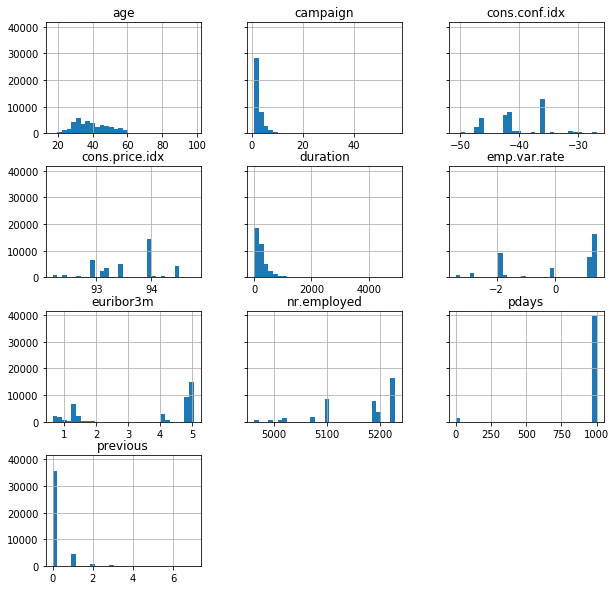

In [7]:
# 每个数值型特征的直方图
display(data.describe())
display(data.describe(include=np.object))
%matplotlib inline
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))

请注意：

- 目标变量 y 几乎 90% 的值都是“no”，这说明大多数客户未订购定期存款。
- 许多预测特征的值为“unknown”。某些特征尤其为甚。我们应该认真思考是什么导致了“unknown”值（是因为这些客户在某种程度上不具代表性吗？）以及如何解决该问题。
- 即使“unknown”被当作预测特征的一个单独类别，但这些观察结果也有可能属于该特征的其他类别之一，这样一来，“unknown”又意味着什么？
- 许多预测特征的类别中没有多少观察结果。如果某个观察结果较少的类别对目标成果的预测有很高的准确性，那么我们是否有足够的证据来进行与其有关的泛化？
- 联系时长偏斜得特别厉害，5 月接近三分之一，12 月不到 1%。这对于预测下一年 12 月的目标变量意味着什么？
- 数值型特征中没有缺失值，或者缺失值已被替换。
  - 几乎所有客户的 `pdays` 的值都接近 1000。这可能是一个占位符值，表示之前没有联系。
- 某些数值型特征具有长尾。是否需要以不同的方式来处理这些包含极大值的少量观察结果？
- 某些数值型特征（尤其是宏观经济特征）出现在不同的存储桶中。是否应将其视为分类型特征？

下面来看看特征与我们要预测的目标有何关系。

y,no,yes
job,,
admin.,0.248167,0.291379
blue-collar,0.235745,0.137500
entrepreneur,0.036445,0.026724
housemaid,0.026103,0.022845
management,0.071030,0.070690
retired,0.035187,0.093534
self-employed,0.034804,0.032112
services,0.099759,0.069612
student,0.016417,0.059267


y,no,yes
marital,,
divorced,0.113166,0.102586
married,0.612783,0.545690
single,0.272190,0.349138
unknown,0.001861,0.002586


y,no,yes
education,,
basic.4y,0.102550,0.092241
basic.6y,0.057568,0.040517
basic.9y,0.152457,0.101940
high.school,0.232133,0.222198
illiterate,0.000383,0.000862
professional.course,0.127175,0.128233
university.degree,0.287239,0.359914
unknown,0.040495,0.054095


y,no,yes
default,,
no,0.776814,0.904526
unknown,0.223104,0.095474
yes,0.000082,0.000000


y,no,yes
housing,,
no,0.454088,0.436638
unknown,0.024160,0.023060
yes,0.521752,0.540302


y,no,yes
loan,,
no,0.823574,0.829741
unknown,0.024160,0.023060
yes,0.152266,0.147198


y,no,yes
contact,,
cellular,0.60991,0.830388
telephone,0.39009,0.169612


y,no,yes
month,,
apr,0.057267,0.116164
aug,0.151116,0.141164
dec,0.002545,0.019181
jul,0.178532,0.139871
jun,0.130212,0.120474
mar,0.007388,0.059483
may,0.352495,0.190948
nov,0.100826,0.089655
oct,0.011027,0.067888


y,no,yes
day_of_week,,
fri,0.191009,0.182328
mon,0.209779,0.182543
thu,0.207344,0.225216
tue,0.195277,0.205388
wed,0.196591,0.204526


y,no,yes
poutcome,,
failure,0.099787,0.130388
nonexistent,0.887107,0.676940
success,0.013106,0.192672


age


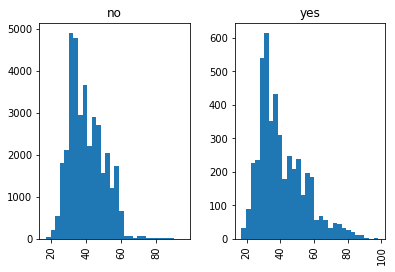

duration


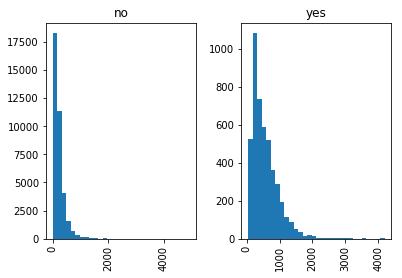

campaign


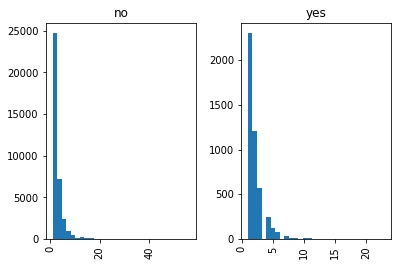

pdays


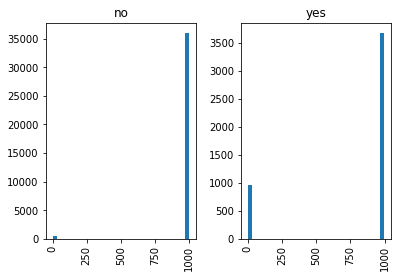

previous


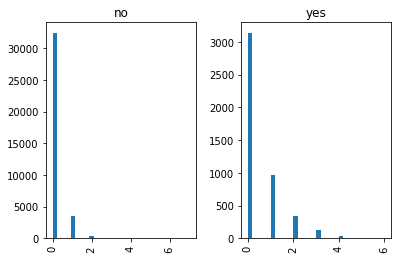

emp.var.rate


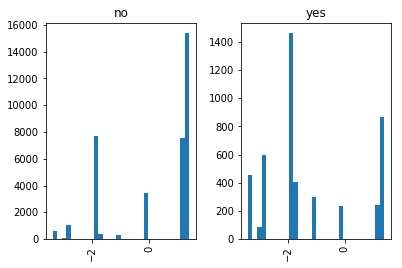

cons.price.idx


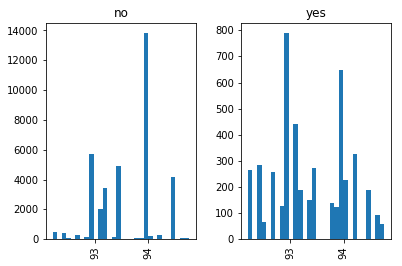

cons.conf.idx


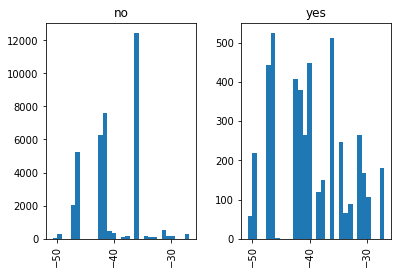

euribor3m


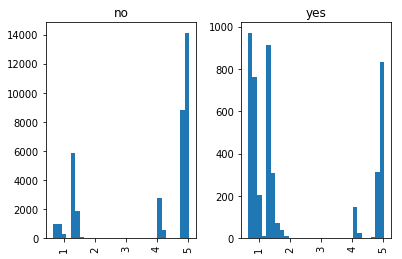

nr.employed


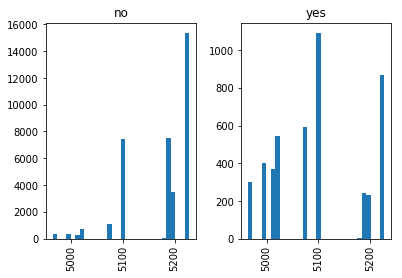

In [8]:
for column in data.select_dtypes(include=['object']).columns:
    if column != 'y':
        display(pd.crosstab(index=data[column], columns=data['y'], normalize='columns'))

for column in data.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = data[[column, 'y']].hist(by='y', bins=30)
    plt.show()

请注意：
- 对于默认状态为“blue-collar”、“married”和“unknown”且通过电话（“telephone”）联系，而且/或者是在 5 月（“May”）联系的客户，认购（“yes”）人数的比例大大低于未认购（“no”）人数的比例。
- 数值型变量在“yes”和“no”认购组中的分布有所不同，但其关系可能比较复杂且不明显。

下面来看看特征之间有何关系。

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


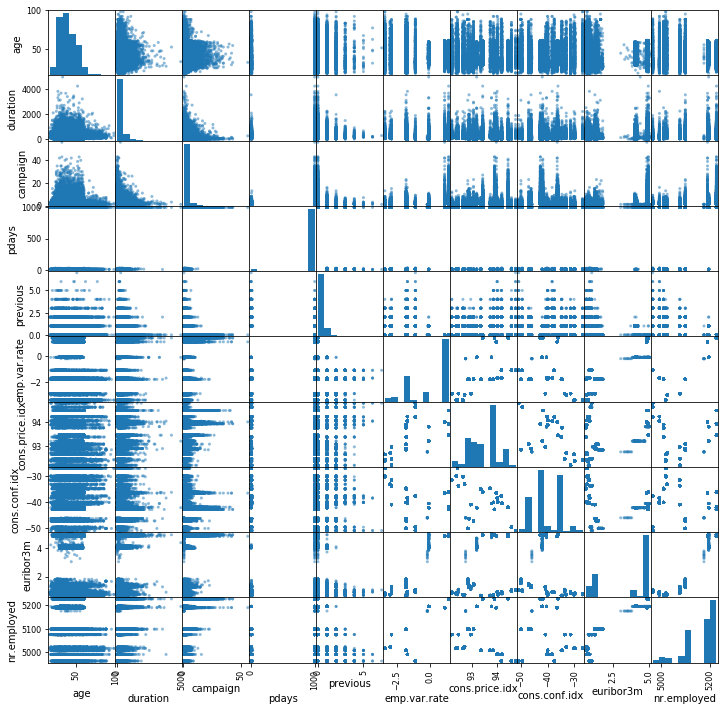

In [9]:
display(data.corr())
pd.plotting.scatter_matrix(data, figsize=(12, 12))
plt.show()

请注意：

- 各个特征之间的关系有很大的差异。有些特征高度负相关；有些特征高度正相关。
- 在许多情况下，特征之间的关系是离散且非线性的。

### 转换

每个机器学习项目几乎都少不了数据清洗。数据清洗不当会带来巨大风险，而且数据清洗也是整个流程中很具主观性的环节之一。

In [10]:
data['no_previous_contact'] = np.where(data['pdays'] == 999, 1, 0) # 当 pdays 值为 999 时要捕获的指示变量
data['not_working'] = np.where(np.in1d(data['job'], ['student', 'retired', 'unemployed']), 1, 0) # 待业人员的指示变量
model_data = pd.get_dummies(data) # 将分类型变量转化为一组指示变量

In [11]:
model_data = model_data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)

### 训练测试拆分

In [12]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))]) # 对数据进行随机排序，然后拆分为三份，第一份占 70%、第二份占 20% 以及第三份占 10%

Amazon SageMaker 的 XGBoost 容器需要采用 libSVM 或 CSV 数据格式的数据。对于本示例，您照旧使用 CSV 即可。注意，首列必须是目标变量，且 CSV 不应包含标头。另请注意，尽管上述操作需要重复进行，但在拆分训练、验证和测试数据后进行是最轻松的。这可以避免因随机重新排序而导致的任何未对齐问题。

In [13]:
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([validation_data['y_yes'], validation_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('validation.csv', index=False, header=False)

现在将文件复制到 Amazon S3，以供 Amazon SageMaker 的托管训练使用。

In [14]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---

## 训练

首先，您需要为 Amazon SageMaker 的 XGBoost 实施指定 Amazon Elastic Container Registry (Amazon ECR) 容器位置。

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

	get_image_uri(region, 'xgboost', '0.90-1').


然后，由于您要使用 CSV 文件格式进行训练，因此要创建几个 `s3_input`，供训练函数用作指向 Amazon S3 中的文件的指针。其中也要指出内容类型为 CSV。

In [16]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

现在，您需要向评估程序指定训练参数。其中包括：
- `xgboost` 算法容器   
- 要使用的 IAM 角色   
- 训练实例类型和数量   
- 输出数据的 Amazon S3 位置
- 算法超参数

然后是 `.fit()` 函数，它用于指定输出数据的 Amazon S3 位置。本例中传入了训练集和验证集。

In [17]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2020-02-19 14:27:40 Starting - Starting the training job...
2020-02-19 14:27:42 Starting - Launching requested ML instances...
2020-02-19 14:28:39 Starting - Preparing the instances for training......
2020-02-19 14:29:34 Downloading - Downloading input data...
2020-02-19 14:30:00 Training - Downloading the training image.Arguments: train
[2020-02-19:14:30:13:INFO] Running standalone xgboost training.
[2020-02-19:14:30:13:INFO] File size need to be processed in the node: 4.35mb. Available memory size in the node: 7990.84mb
[2020-02-19:14:30:13:INFO] Determined delimiter of CSV input is ','
[14:30:13] S3DistributionType set as FullyReplicated
[14:30:13] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-02-19:14:30:13:INFO] Determined delimiter of CSV input is ','
[14:30:13] S3DistributionType set as FullyReplicated
[14:30:13] 8238x59 matrix with 486042 entries loaded from /opt/ml/input/data/validation?format=csv&label_co


2020-02-19 14:30:25 Uploading - Uploading generated training model
2020-02-19 14:30:25 Completed - Training job completed
Training seconds: 51
Billable seconds: 51


---

## 托管
现在您已经使用数据训练了 `xgboost` 算法，下面部署一个托管在实时终端节点后面的模型。

In [18]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

---------------!

---

## 评估
有多种方法可以比较机器学习模型的性能，但开始时先简单地比较实际值与预测值。在本例中，您只是简单地预测客户是订购了定期存款 (`1`)，还是没有订购定期存款 (`0`)，这会生成一个简单的混淆矩阵。

首先，您需要确定如何将数据传入终端节点以及如何从终端节点接受数据。数据目前以 NumPy 数组的形式存储在笔记本实例的内存中。要通过 HTTP POST 请求发送数据，您需要将其序列化为 CSV 字符串，然后对生成的 CSV 进行解码。

**注意**：对于 CSV 格式的推理，Amazon SageMaker XGBoost 要求数据一定不能包含目标变量。

In [19]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

现在使用简单的函数来执行以下操作：  

1. 遍历测试数据集  
1. 将其拆分为小批量的行   
1. 将这些小批量转化为 CSV 字符串负载（注意，要先从数据集里删除目标变量）  
1. 通过调用 XGBoost 终端节点来检索小批量预测结果  
1. 收集预测结果并将模型提供的 CSV 输出转化为 NumPy 数组  

In [20]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict(test_data.drop(['y_no', 'y_yes'], axis=1).as_matrix())

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


接下来查看混淆矩阵，看看与实际情况相比，模型预测的效果如何。

In [21]:
pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions), rownames=['actuals'], colnames=['predictions'])

predictions,0.0,1.0
actuals,,
0,3594,42
1,389,94


在大约 4000 位潜在客户中，模型预测有 136 人会订购，而实际上其中有 94 人订购了。还有 389 位订购了定期存款的客户没有被预测出来。这个结果不太理想，但我们可以（而且应该）对模型进行调优来做出改进。最重要的是，该模型轻而易举地就达到了与这些发表的成果 [此处](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf) 相似的准确率。

**注意**：由于算法的子样本中存在一些随机元素，因此您的结果可能会与本文的结果有些许不同。

### 清理

如果用完了笔记本，请运行以下单元格。这会删除您创建的托管终端节点，以免未关闭的闲置实例产生费用。

In [22]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)